In [ ]:
#Import modules
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import optimizers
from keras import models
from keras import layers

In [ ]:
#Specify path for training, validation and testing data
train_dir = '/content/drive/MyDrive/Rut-Subsidence-Train-Val-Split-80-20-New/train'
test_dir = '/content/drive/MyDrive/Rut-Subsidence-Train-Val-Split-80-20-New/test'
validation_dir = '/content/drive/MyDrive/Rut-Subsidence-Train-Val-Split-80-20-New/val'

## Preprocess and Augmentation of Images

In [ ]:
#Instante trainig ImageDataGenerator object
#rescale to ensure that all pixel values are in range [0-1]
#rotation_range: allow for 40deg. random rotation of images
#width_shift_range & height_shift_range: fraction of total width and height that image can be shifted by
#shear_range: range in which can shear image
#zoom_range: range in which can zoom image
#horizontal_flip: allows for horizontal flip of image
#fill_mode: areas of image that fall outside of original boundaries are filled as so aaa|abcd|ddd, where | denotes a boundary
train_datagenerator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#Instantiate testing ImageDataGenerator object
#rescale to ensure that all pixel values are in range [0-1]
#no further data augmentation
test_datagenerator = ImageDataGenerator(rescale=1./255)

#Define function to generate augmented training dataset from training data directory
def train_prep(data_location, target_image_size):
    training_generator = train_datagenerator.flow_from_directory(
        data_location,
        target_size = target_image_size,
        batch_size = 20,
        class_mode = 'binary')
    return training_generator

#Define function to generate validation/testing dataset from data directory
def val_test_prep(data_location, target_image_size):
    val_test_generator = test_datagenerator.flow_from_directory(
        data_location,
        target_size = target_image_size,
        batch_size = 20,
        class_mode = 'binary')
    return val_test_generator

#Generate training data
train_generator = train_prep(train_dir, (150, 150))

#Generate validation data
validation_generator = val_test_prep(validation_dir, (150, 150))

Found 286 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


## Instantiate pre-trained convolutional base

In [ ]:
#Load weights learned from training on image net dataset
#Don't include top (will add our own dense classifier)
convolutional_base = VGG16(weights = 'imagenet', include_top = False)

58889256/58889256 [==============================] - 0s 0us/step


## Add densely connected layers on top of convolutional base

In [ ]:
#Create sequential model
my_model = models.Sequential()
#Add convolutional base
my_model.add(convolutional_base)
#Add Global Average Pooling layer to downscale parameter space
my_model.add(layers.GlobalAveragePooling2D())
#Add dense layers to learn classes and output binary predictions
my_model.add(layers.Dense(256, activation = 'relu'))
my_model.add(layers.Dense(1, activation = 'sigmoid'))

#Display summary of model architecture
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


## Freeze convolutional base

In [ ]:
convolutional_base.trainable = False

## Compile model

In [ ]:
my_model.compile(loss = 'binary_crossentropy',
                 optimizer = optimizers.RMSprop(learning_rate = 2e-5),
                 metrics = ['acc'])

In [ ]:
batch_size = 20

## Train the densely connected layers on training dataset

In [ ]:
history_dense_top = my_model.fit(
      train_generator,
      steps_per_epoch=int(286 /batch_size),
      epochs=30,
      validation_data=validation_generator,
      validation_steps=int(72 /batch_size))

Epoch 1/30
14/14 [==============================] - 122s 9s/step - loss: 0.6946 - acc: 0.5263 - val_loss: 0.6677 - val_acc: 0.6333
Epoch 2/30
14/14 [==============================] - 82s 6s/step - loss: 0.6741 - acc: 0.5752 - val_loss: 0.6693 - val_acc: 0.6500
Epoch 3/30
14/14 [==============================] - 81s 6s/step - loss: 0.6686 - acc: 0.6541 - val_loss: 0.6533 - val_acc: 0.7000
Epoch 4/30
14/14 [==============================] - 86s 6s/step - loss: 0.6665 - acc: 0.6617 - val_loss: 0.6555 - val_acc: 0.7167
Epoch 5/30
14/14 [==============================] - 81s 6s/step - loss: 0.6544 - acc: 0.7293 - val_loss: 0.6337 - val_acc: 0.7667
Epoch 6/30
14/14 [==============================] - 85s 6s/step - loss: 0.6462 - acc: 0.7406 - val_loss: 0.6484 - val_acc: 0.7167
Epoch 7/30
14/14 [==============================] - 81s 6s/step - loss: 0.6446 - acc: 0.7707 - val_loss: 0.6403 - val_acc: 0.7333
Epoch 8/30
14/14 [==============================] - 85s 6s/step - loss: 0.6373 - acc: 0.7

In [ ]:
#Evaluate model before fine tuning
test_generator = test_datagenerator.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss_, test_acc_ = my_model.evaluate(test_generator, steps=37)
print('test acc:', test_acc_)

Found 40 images belonging to 2 classes.
 2/37 [>.............................] - ETA: 6:24 - loss: 0.5153 - acc: 0.8750

37/37 [==============================] - 16s 316ms/step - loss: 0.5153 - acc: 0.8750
test acc: 0.875


## Unfreeze final 3 layers of convolutional base

In [ ]:
#Display structure of convolutional base
convolutional_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
#Unfreeze all convolutional layers in block5
convolutional_base.trainable = True

for layer in convolutional_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
#Compile model
my_model.compile(loss = 'binary_crossentropy',
                 optimizer = optimizers.RMSprop(learning_rate = 1e-5),
                 metrics = ['acc'])

## Finetune model

In [ ]:
history_final = my_model.fit(
              train_generator,
              steps_per_epoch=int(286/batch_size),
              epochs=100,
              validation_data=validation_generator,
              validation_steps=int(72/batch_size))

Epoch 1/100
14/14 [==============================] - 17s 1s/step - loss: 0.5082 - acc: 0.8045 - val_loss: 0.4356 - val_acc: 0.8167
Epoch 2/100
14/14 [==============================] - 14s 1s/step - loss: 0.3839 - acc: 0.8722 - val_loss: 0.3844 - val_acc: 0.8333
Epoch 3/100
14/14 [==============================] - 15s 1s/step - loss: 0.3340 - acc: 0.8684 - val_loss: 0.3407 - val_acc: 0.8500
Epoch 4/100
14/14 [==============================] - 14s 1s/step - loss: 0.2897 - acc: 0.9098 - val_loss: 0.3544 - val_acc: 0.8333
Epoch 5/100
14/14 [==============================] - 14s 1s/step - loss: 0.2665 - acc: 0.8985 - val_loss: 0.3260 - val_acc: 0.8333
Epoch 6/100
14/14 [==============================] - 14s 1s/step - loss: 0.2525 - acc: 0.9023 - val_loss: 0.3247 - val_acc: 0.8667
Epoch 7/100
14/14 [==============================] - 14s 1s/step - loss: 0.2452 - acc: 0.9023 - val_loss: 0.3530 - val_acc: 0.8667
Epoch 8/100
14/14 [==============================] - 14s 1s/step - loss: 0.2359 - a

## Plotting the Accuracy 

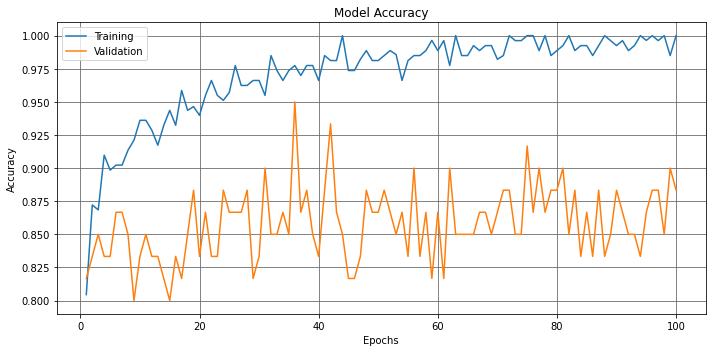

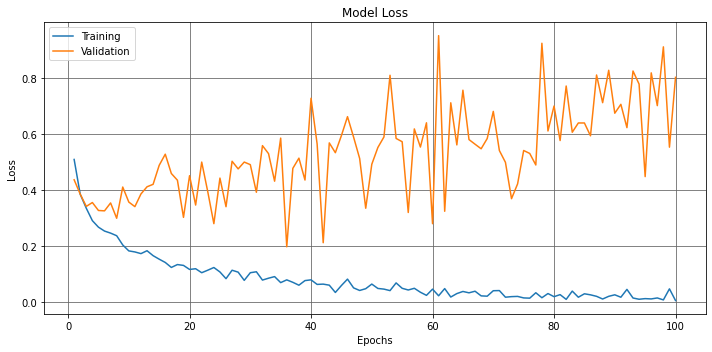

In [ ]:
import matplotlib.pyplot as plt
acc = history_final.history['acc']
val_acc = history_final.history['val_acc']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs_range = range(1, len(history_final.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()


## Evaluate performance of fine-tuned model on testing dataset

In [ ]:
test_generator = test_datagenerator.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss, test_acc = my_model.evaluate(test_generator, steps=37)
print('test acc:', test_acc)

Found 40 images belonging to 2 classes.
 2/37 [>.............................] - ETA: 40s - loss: 0.1120 - acc: 0.9750

37/37 [==============================] - 2s 33ms/step - loss: 0.1120 - acc: 0.9750
test acc: 0.9750000238418579


In [ ]:
my_model.save("/content/drive/MyDrive/VGG16_transfer-Rut+Subsidence.h5")

## Testing on a Single Image

1/1 [==============================] - 0s 389ms/step


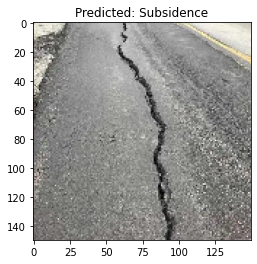

In [ ]:
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os 
from keras.models import load_model
  
model = load_model('/content/drive/MyDrive/VGG16_transfer-Rut+Subsidence.h5')
  
image = load_img('/content/drive/MyDrive/Rut+Subsidence_Test-NEW/Subsidence_106.jpg', target_size=(150, 150))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,150,150,3)
label = model.predict(img)[0]
if label < 0.5:
    plt.title("Predicted: Rut")
else:
    plt.title("Predicted: Subsidence")

plt.imshow(image)


## Prediction on Test Images- Rut+Subsidence -Test-NEW Folder Images

In [ ]:
model = load_model('/content/drive/MyDrive/VGG16_transfer-Rut+Subsidence.h5') 

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 1s 712ms/step


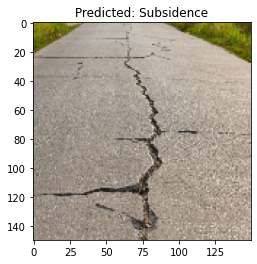

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 411ms/step


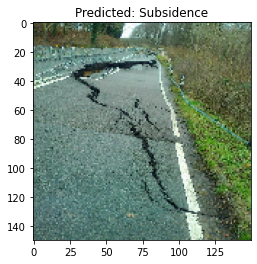

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 392ms/step


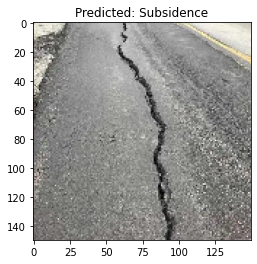

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 1s 532ms/step


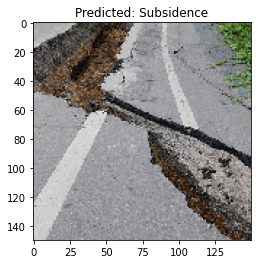

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 1s 541ms/step


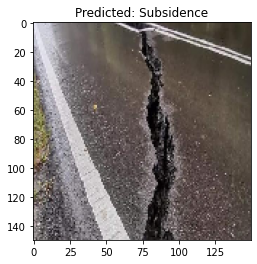

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 472ms/step


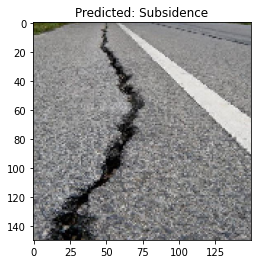

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 446ms/step


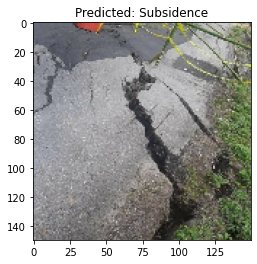

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 1s 676ms/step


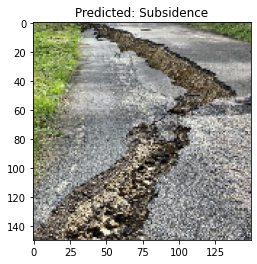

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 406ms/step


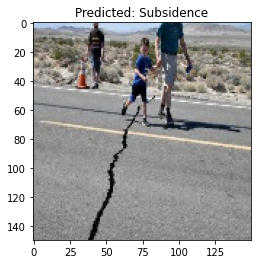

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 478ms/step


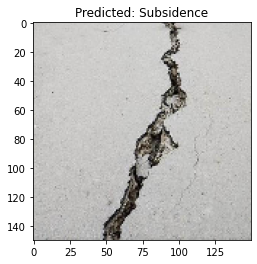

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 1s 602ms/step


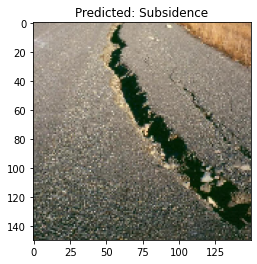

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 395ms/step


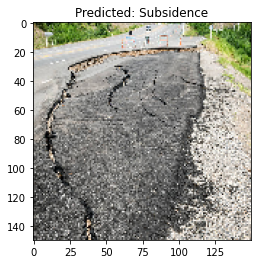

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 399ms/step


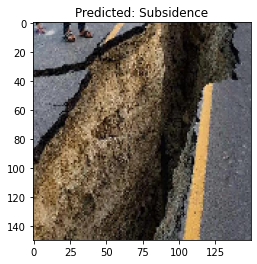

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 1s 546ms/step


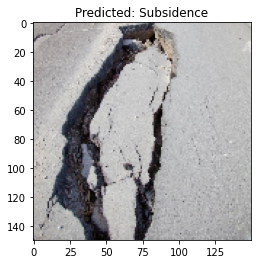

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 433ms/step


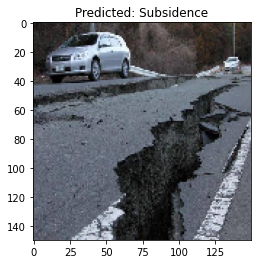

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 1s 710ms/step


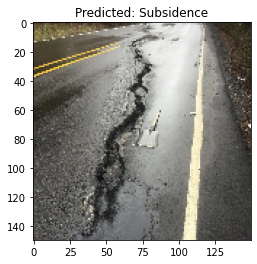

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 1s 535ms/step


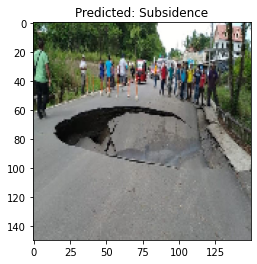

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 470ms/step


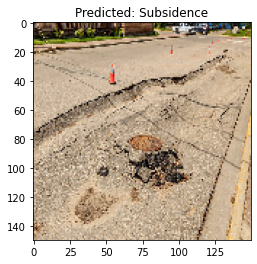

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 456ms/step


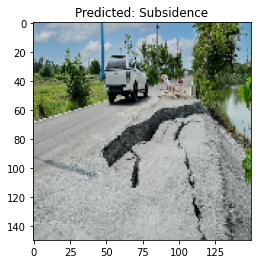

-------------------------------------------------------------------
Actual: Subsidence
1/1 [==============================] - 0s 475ms/step


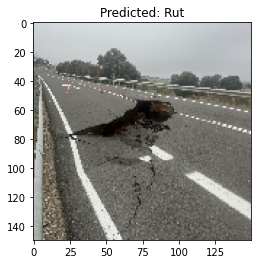

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 479ms/step


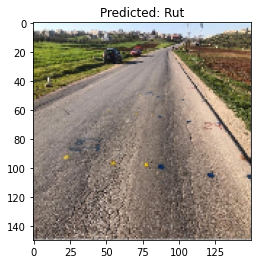

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 1s 813ms/step


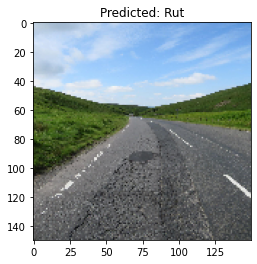

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 434ms/step


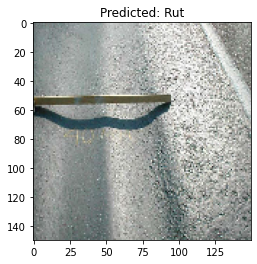

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 399ms/step


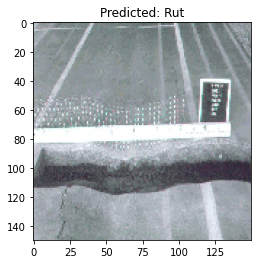

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 419ms/step


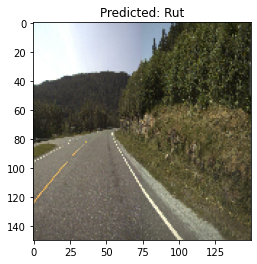

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 237ms/step


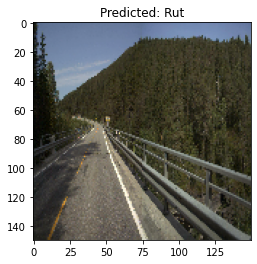

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 281ms/step


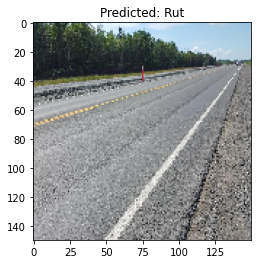

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 246ms/step


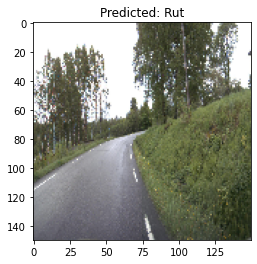

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 225ms/step


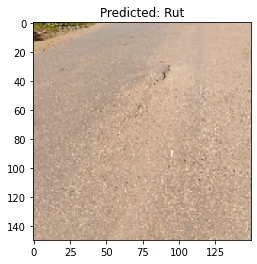

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 264ms/step


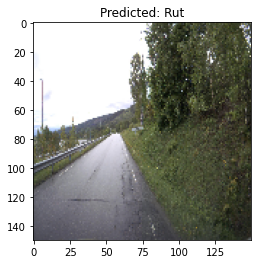

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 272ms/step


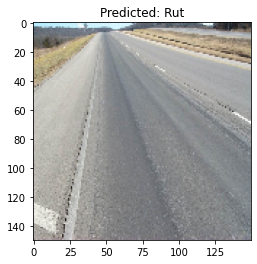

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 240ms/step


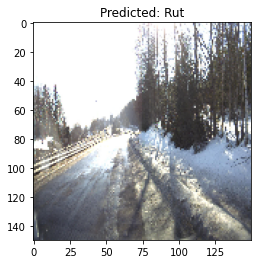

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 267ms/step


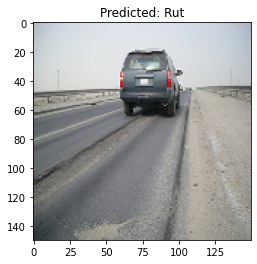

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 286ms/step


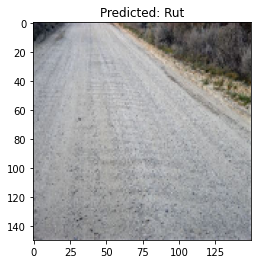

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 437ms/step


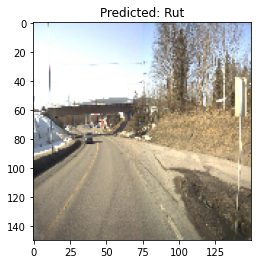

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 450ms/step


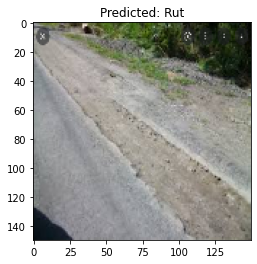

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 467ms/step


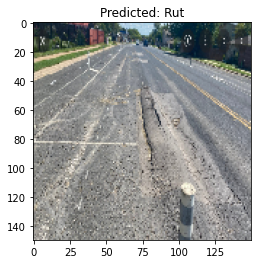

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 460ms/step


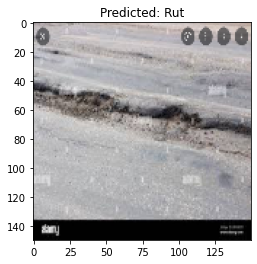

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 285ms/step


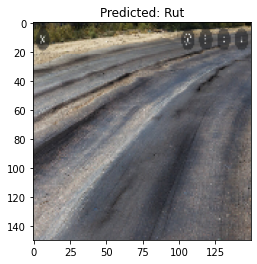

-------------------------------------------------------------------
Actual: Rut
1/1 [==============================] - 0s 279ms/step


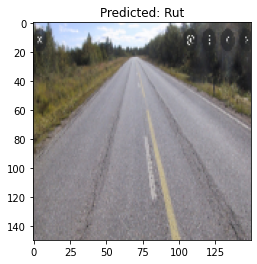

In [ ]:
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
import os

y_true = []
y_pred = []  
model = load_model('/content/drive/MyDrive/VGG16_transfer-Rut+Subsidence.h5')
fig, ax = plt.subplots()  
for img in os.listdir('/content/drive/MyDrive/Rut+Subsidence_Test-NEW/'):
    img_class_name = img.split('_')[0]
    if img_class_name == 'Rut':
        y_true.append(0) 
    else:
        y_true.append(1)
    print(f"-------------------------------------------------------------------")
    print(Fore.RED + "Actual:", img_class_name)
    image = load_img('/content/drive/MyDrive/Rut+Subsidence_Test-NEW/'+img, target_size=(150, 150))
    orig_img = image
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,150,150,3)
    label = model.predict(img)
    if label < 0.5:
      plt.title ("Predicted: Rut")
      y_pred.append(0)
    else:
      plt.title("Predicted: Subsidence")
      y_pred.append(1)

    plt.imshow(image)
    plt.show()

[[20  0]
 [ 1 19]]


[Text(0, 0.5, 'Rut'), Text(0, 1.5, 'Subsidence')]

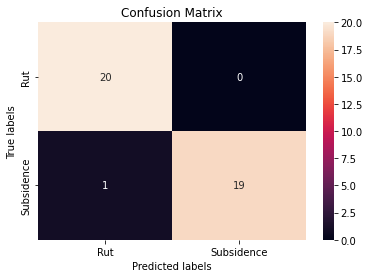

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cfm = confusion_matrix(y_true, y_pred)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rut', 'Subsidence'])
ax.yaxis.set_ticklabels(['Rut', 'Subsidence'])

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

